<h1 align="center">Feature Engineering and Building Model</h1>

# 1. Load dữ liệu

In [39]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
warnings.filterwarnings('ignore')


In [40]:
# load lại dữ liệu
df = pd.read_csv('clean_data_1k.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 947 entries, 0 to 946
Data columns (total 20 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   price         947 non-null    float64
 1   brand         947 non-null    object 
 2   ram           947 non-null    float64
 3   ram_type      947 non-null    object 
 4   display_size  946 non-null    float64
 5   display_type  946 non-null    object 
 6   resolution    946 non-null    object 
 7   screen_rate   321 non-null    float64
 8   screen_panel  946 non-null    object 
 9   length        943 non-null    float64
 10  width         943 non-null    float64
 11  thickness     943 non-null    float64
 12  cpu_brand     947 non-null    object 
 13  gpu_brand     947 non-null    object 
 14  ssd           944 non-null    float64
 15  os            944 non-null    object 
 16  weight        947 non-null    float64
 17  cpu_point     869 non-null    float64
 18  gpu_point     807 non-null    

# 2. Trích xuất đặc trưng


## 2.1 Định nghĩa hàm đánh giá kết quả trích xuất đặc trưng


In [41]:
# function to calculate mean absolute percentage error to test model with feature engineering
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

# function to calculate mean absolute percentage error (MAPE) to test model with feature engineering
def test_model(X_train, X_test, y_train, y_test):
    model = LinearRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return mean_absolute_percentage_error(y_test, y_pred)


## 2.2 Xử lý và mã hóa dữ liệu dạng category


- Xóa tất cả giá trị nan trong các cột có dạng category


In [42]:
cat_cols = df.select_dtypes(include=['object']).columns
df = df.dropna(subset=cat_cols)
df.select_dtypes(include=['object']).info()


<class 'pandas.core.frame.DataFrame'>
Index: 943 entries, 0 to 946
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   brand         943 non-null    object
 1   ram_type      943 non-null    object
 2   display_type  943 non-null    object
 3   resolution    943 non-null    object
 4   screen_panel  943 non-null    object
 5   cpu_brand     943 non-null    object
 6   gpu_brand     943 non-null    object
 7   os            943 non-null    object
 8   features      943 non-null    object
dtypes: object(9)
memory usage: 73.7+ KB


- Xóa các giá trị không chiếm quá 1% tổng số dòng


In [43]:
# remove values that have percentage less than 1% in category columns
for col in cat_cols:
    value_counts = df[col].value_counts(normalize=True)
    to_remove = value_counts[value_counts <= 0.01].index
    # drop rows that have value in to_remove
    df[col].replace(to_remove, np.nan, inplace=True)
    df = df.dropna(subset=[col])


In [44]:
# print value counts of each column that have type object
for col in cat_cols:
    print(df[col].value_counts())


brand
HP        348
LENOVO    147
ASUS      143
DELL      103
MSI        79
ACER       55
LG         12
Name: count, dtype: int64
ram_type
DDR4       677
DDR5       172
LPDDR5      22
LPDDR4X     16
Name: count, dtype: int64
display_type
FHD       571
HD         89
QHD        65
WUXGA      42
WQXGA      40
HD+        37
FHD+       19
WQUXGA     13
QHD+       11
Name: count, dtype: int64
resolution
1920 x 1080    571
1366 x 768      89
1920 x 1200     61
2560 x 1600     61
2560 x 1440     55
1600 x 900      37
3840 x 2400     13
Name: count, dtype: int64
screen_panel
IPS     723
TN      151
OLED     13
Name: count, dtype: int64
cpu_brand
INTEL    610
AMD      277
Name: count, dtype: int64
gpu_brand
INTEL     387
NVIDIA    332
AMD       168
Name: count, dtype: int64
os
WINDOWS    887
Name: count, dtype: int64
features
FINGERPRINT READER    718
WEB CAMERA            169
Name: count, dtype: int64


In [45]:
# remove OS column cuz it only have 1 unique value
df = df.drop(columns=['os'])


- Mã hóa one hot cho các cột có dạng category


In [46]:
brand_col = df['brand']
# mã hóa các cột dạng category
cat_cols = df.select_dtypes(include='object').columns
df = pd.get_dummies(df, columns=cat_cols, drop_first=True)
# replace false by 0 and true by 1 on boolean columns
bool_cols = df.select_dtypes(include='bool').columns
df[bool_cols] = df[bool_cols].replace({False: 0, True: 1})
df[bool_cols] = df[bool_cols].astype('int64')
# concat brand column
df = pd.concat([df, brand_col], axis=1)
print("Number of columns after encoding: ", len(df.columns) - 2)

Number of columns after encoding:  39


## 2.3 Chia dữ liệu train và test


In [47]:
trainset, testset = train_test_split(df, stratify=df['brand'], test_size=0.2, random_state=2023)


In [48]:
print("Trainset shape: ", trainset.shape[0], "rows and ", trainset.shape[1] - 2, "columns")
print("Trainset shape: ", testset.shape[0], "rows and ", testset.shape[1] - 2, "columns")

Trainset shape:  709 rows and  39 columns
Trainset shape:  178 rows and  39 columns


## 2.4 Xử lý dữ liệu trống, xử lý outlier và chuẩn hóa dữ liệu


### 2.4.1 Xử lý dữ liệu trống


- Vì các cột category đã được xử lý ở trên nên chỉ còn các cột dạng số bị thiếu dữ liệu

Với các cột numeric, ta sẽ tiến hành fill nan sử dụng IterativeImputer (trừ screen_rate được điền với giá trị mặc định là 60 và ssd là 0)

IterativeImputer là một phương pháp xử lý ngoại lệ trong machine learning để điền giá trị cho các dữ liệu bị thiếu trong tập dữ liệu. Phương pháp này được sử dụng để ước lượng và điền giá trị cho các dữ liệu thiếu dựa trên các giá trị đã có sẵn trong tập dữ liệu.

Mô hình mặc định của IterativeImputer trong scikit-learn là BayesianRidge. Đây là một mô hình hồi quy Bayesian dựa trên phân phối Gaussian, được sử dụng để dự đoán giá trị thiếu trong quá trình điền giá trị bằng phương pháp IterativeImputer.

Ở mỗi bước, một cột đặc trưng được chỉ định là đầu ra y và các cột đặc trưng khác được coi là đầu vào X. Một biến hồi quy được fit trên tập (X, y) đối với y đã biết. Sau đó, biến hồi quy được sử dụng để dự đoán các giá trị còn thiếu của y. Điều này được thực hiện cho từng tính năng và được lặp lại cho các vòng quy nạp max_iter. 

In [49]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.base import TransformerMixin



# apply IterativeImputer to fill numeric columns
class FillNanNumberics(TransformerMixin):
    def fit(self, X: pd.DataFrame, y=None):
        X['screen_rate'] = X['screen_rate'].fillna(60)
        X['ssd'] = X['ssd'].fillna(0)
        self.num_cols = X.select_dtypes(include='float64').columns
        self.imputer = IterativeImputer(max_iter=10, random_state=2023)
        self.imputer.fit(X[self.num_cols])
        return self
    def transform(self, X: pd.DataFrame, y=None):
        X[self.num_cols] = self.imputer.transform(X[self.num_cols])
        return X
    


### 2.3.2 Xử lý ngoại lệ với dữ liệu số


"abs(skewness) < 0.5 and abs(kurt - 3) < 0.5" được sử dụng để kiểm tra xem một biến có tuân theo phân phối chuẩn hay không. 

- Skewness (độ lệch): Độ lệch đo lường độ chệch của phân phối so với phân phối chuẩn. Khi abs(skewness) < 0.5, điều này có nghĩa là độ lệch của phân phối gần với 0 và do đó có xu hướng gần với phân phối chuẩn.

- Kurtosis (độ nhọn): Độ nhọn đo lường độ cao hoặc thấp của các giá trị dữ liệu so với phân phối chuẩn. Phân phối chuẩn có độ nhọn bằng 3. Khi abs(kurt - 3) < 0.5, điều này ngụ ý rằng độ nhọn của phân phối gần với 3 và do đó có xu hướng gần với phân phối chuẩn.

In [50]:
from scipy.stats import skew

class HandleOutlier(TransformerMixin):
    def fit(self, X: pd.DataFrame, y=None):
        num_cols = X.select_dtypes(include='float64').columns
        self.col_to_handle = num_cols.drop('price')
        self.dist = {}
        self.upper_boundary = {}
        self.lower_boundary = {}
        for col in self.col_to_handle:
            skewness = skew(df[col])
            kurt = df[col].kurtosis()
            # Kiểm tra độ méo lệch và độ nhọn để đánh giá phân bố
            q3, q1 = np.percentile(X[col], [75, 25])
            IQR = q3 - q1 
            if abs(skewness) < 0.5 and abs(kurt - 3) < 0.5:
                # self.dist = 'normal'
                self.dist[col] = 'normal'
                mean = X[col].mean()
                self.upper_boundary[col] = mean + 1.5 * IQR
                self.lower_boundary[col] = mean - 1.5 * IQR
            else:
                self.dist[col]='skewed'
                self.upper_boundary[col] = q3 + 1.5 * IQR
                self.lower_boundary[col] = q1 - 1.5 * IQR
        return self
    def transform(self, X: pd.DataFrame, y=None):
        for col in self.col_to_handle:
            X[col][X[col] >= self.upper_boundary[col]] = self.upper_boundary[col]
            X[col][X[col] <= self.lower_boundary[col]] = self.lower_boundary[col]

        return X


### 2.3.3 Chuẩn hóa dữ liệu số


In [51]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer


class StandardScalerDataset(TransformerMixin):
    def fit(self, X: pd.DataFrame, y=None):
        self.num_cols = X.select_dtypes(include='float64').columns
        self.num_cols = self.num_cols.drop('price')
        self.scaler = StandardScaler()
        self.scaler.fit(X[self.num_cols])
        return self
    def transform(self, X: pd.DataFrame, y=None):
        X[self.num_cols] = self.scaler.transform(X[self.num_cols])
        return X

## 2.5 Xử lý dữ liệu trên tập train và test


In [52]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
pipe_line = Pipeline(steps=[
    ('fill_nan_numberics', FillNanNumberics()),
    ('handle_outliers', HandleOutlier()),
    ('standard_scaler', StandardScalerDataset()),
])

In [53]:
# function to plot numeric data
def plot_num_data(df, col):
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 4))
    sns.histplot(df[col], bins=50, ax=axes[0])
    # plot kde line
    sns.kdeplot(df[col], ax=axes[1])
    sns.boxplot(data=df, x=col, ax=axes[2])
    # plot mean line
    mean = df[col].mean()
    axes[0].axvline(mean, color='r', linestyle='--')
    axes[1].axvline(mean, color='r', linestyle='--')
    # set text size for axes
    for ax in axes:
        ax.tick_params(axis='x', labelsize=10)
        ax.tick_params(axis='y', labelsize=10)
        # set labels size
        ax.set_xlabel(col, fontsize=10)
        ax.set_ylabel('Count', fontsize=10)
    plt.suptitle(f'{col} Distribution', fontsize=15)
    plt.tight_layout()


- Trước khi xử lý

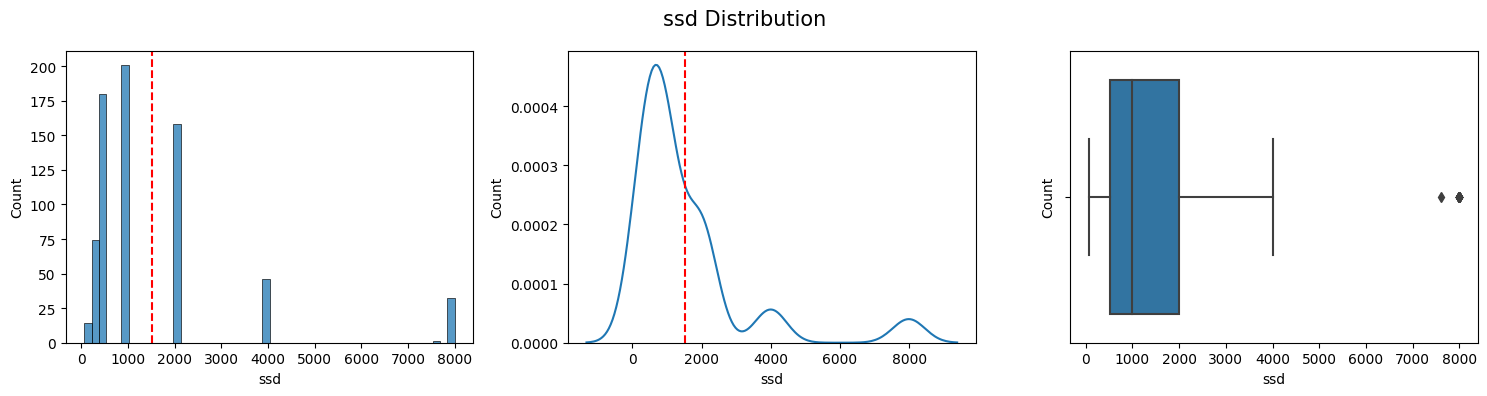

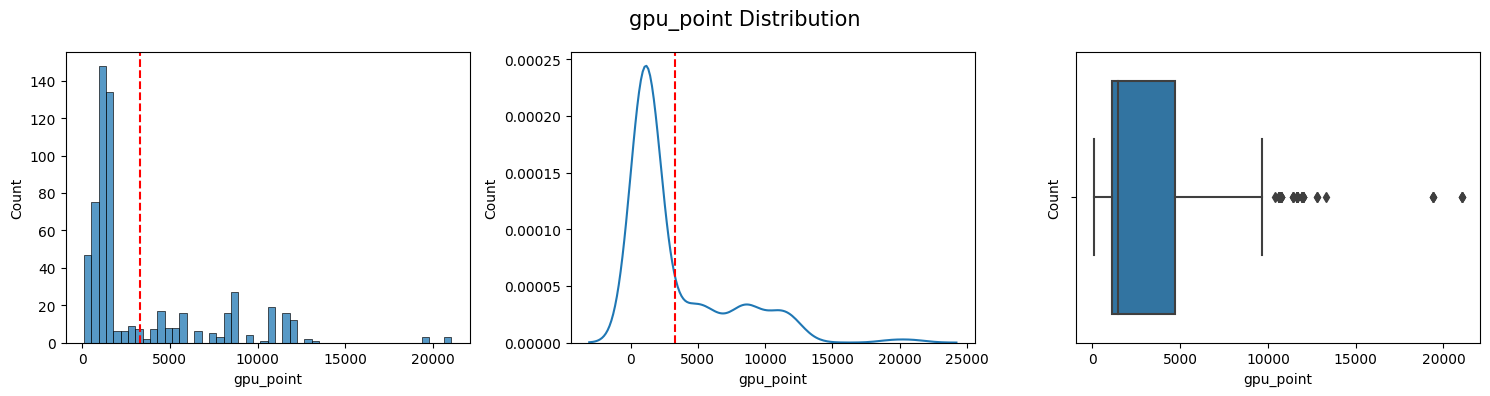

In [54]:
cols = ['ssd', 'gpu_point']
for col in cols:
    plot_num_data(trainset, col)

In [55]:
trainset = pipe_line.fit_transform(trainset)
testset = pipe_line.fit_transform(testset)
X_train = trainset.drop(columns=['price', 'brand'], axis=1)
y_train = trainset['price']
X_test = testset.drop(columns=['price', 'brand'], axis=1)
y_test = testset['price']

- Sau khi xử lý

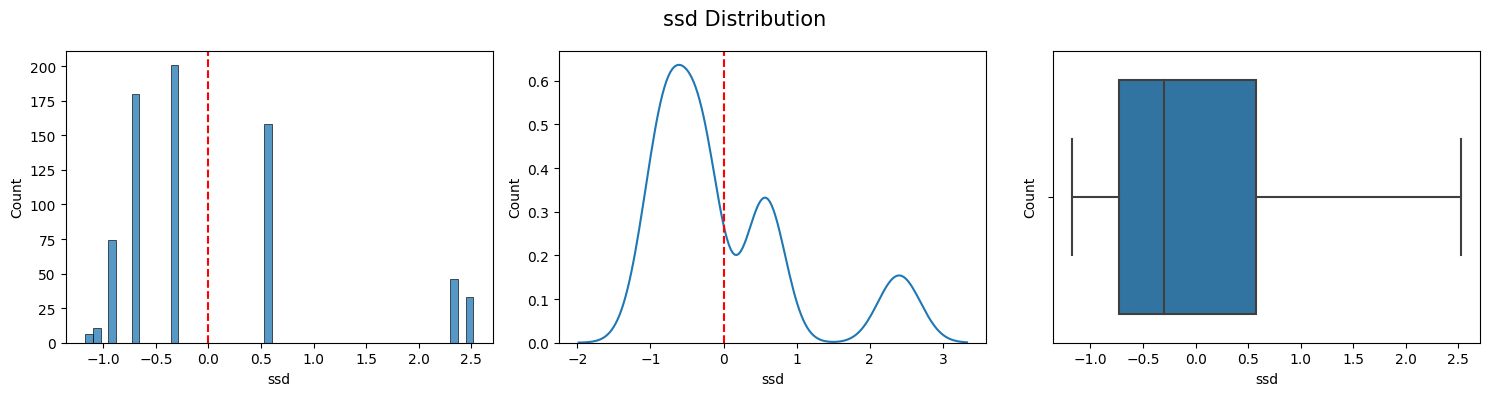

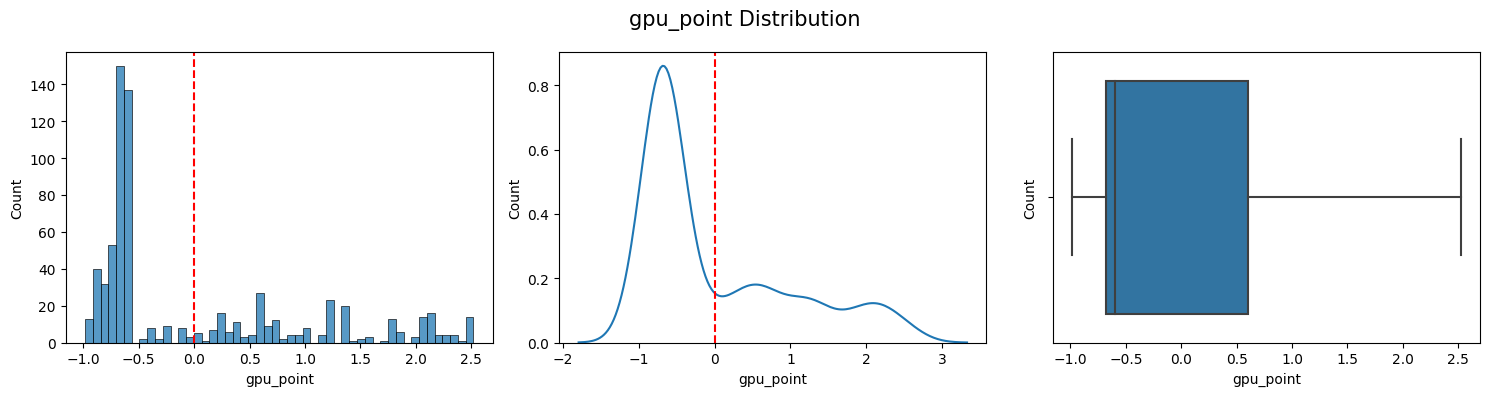

In [56]:
cols = ['ssd', 'gpu_point']
for col in cols:
    plot_num_data(trainset, col)


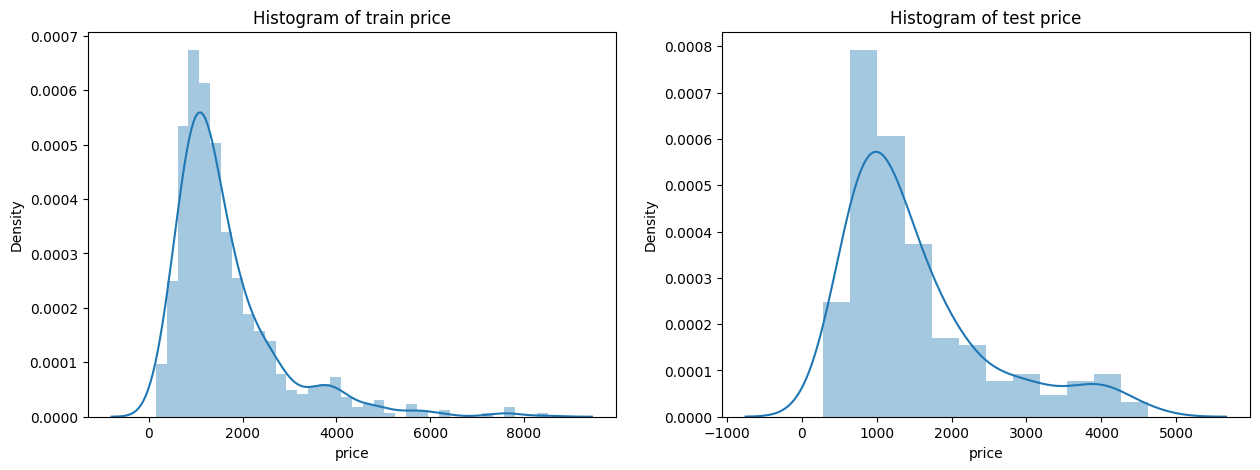

In [57]:

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
# plot histogram of price
sns.distplot(y_train, ax=ax[0])
ax[0].set_title('Histogram of train price')
sns.distplot(y_test, ax=ax[1])
ax[1].set_title('Histogram of test price')
plt.show()


## 2.6 Lựa chọn đặc trưng


- Từ tập train, tiếp tục chia thành tập fe_trainset và tập fe_testset để tiến hành lựa chọn đặc trưng

In [58]:
fe_trainset, fe_testset = train_test_split(
    trainset, stratify=trainset['brand'], test_size=0.2, random_state=2023)

fe_trainset.drop(['brand'], axis=1, inplace=True)
fe_testset.drop(['brand'], axis=1, inplace=True)

fe_X_train = fe_trainset.drop(['price'], axis=1)
fe_y_train = fe_trainset['price']
fe_X_test = fe_testset.drop(['price'], axis=1)
fe_y_test = fe_testset['price']


In [59]:
print("MAPE with orginal trainset: ", test_model(fe_X_train, fe_X_test, fe_y_train, fe_y_test))

MAPE with orginal trainset:  0.29630698430325464


### 2.6.1 Loại bỏ các cột có độ tương quan thấp


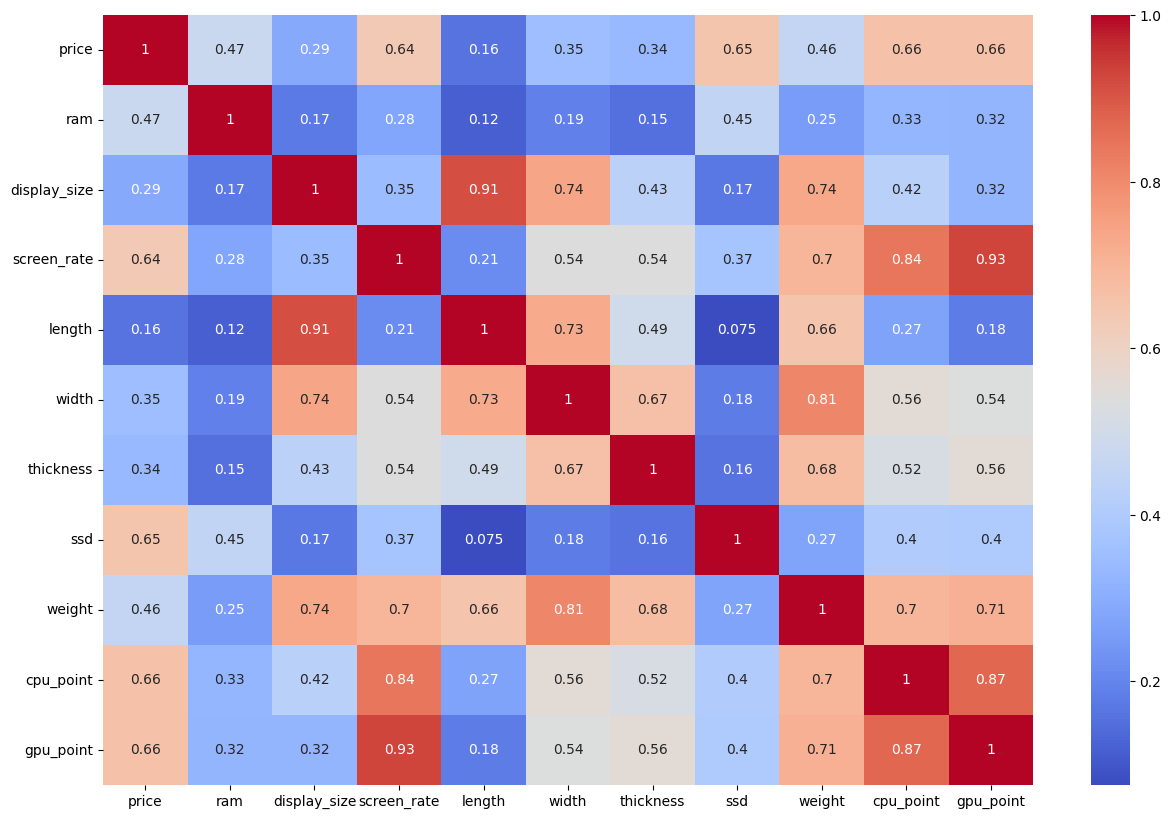

In [60]:
# get numeric columns that have type float64
num_cols = trainset.select_dtypes(include='float64').columns
# plot correlation matrix
corr = trainset[num_cols].corr()
plt.figure(figsize=(15, 10))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.show()

- Ý tưởng: lần lượt duyệt và tính độ lỗi dựa trên độ tương quan của các đặc trưng từ có độ tương quan từ cao đến thấp với cột price

In [61]:
def corr_feature_selection(X_train, X_test, y_train, y_test):
    df = pd.concat([X_train, y_train], axis=1)
    err_list = []
    for i in range(2, len(X_train.columns) + 1):
        best_col = df.corr()['price'].sort_values(ascending=False).head(i)
        best_col = best_col.drop('price')
        feat_col = best_col.index
        err = test_model(X_train[feat_col], X_test[feat_col], y_train, y_test)
        err_list.append((i, err))
    return err_list

Min MAPE: 0.28622913624286533 with 15 features


Text(0.5, 1.0, 'Corr selected features')

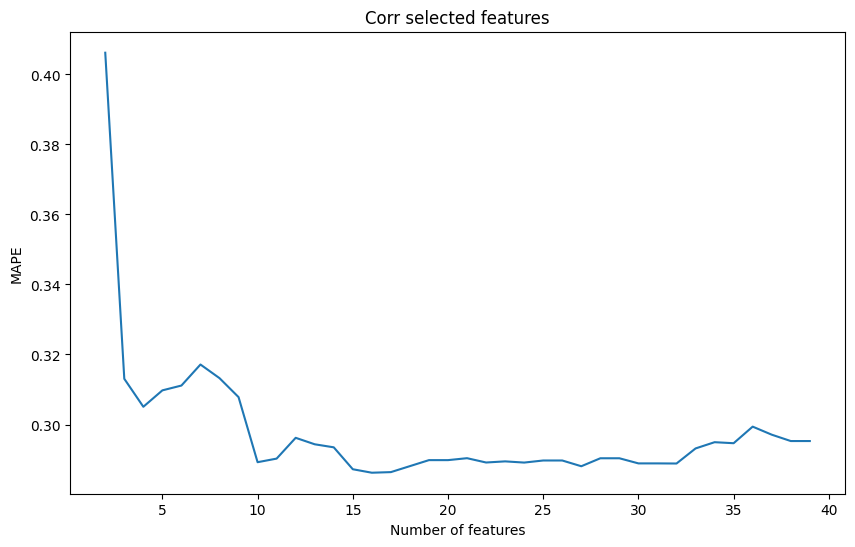

In [62]:
err_corr = corr_feature_selection(fe_X_train, fe_X_test, fe_y_train, fe_y_test)
min_err = min(err_corr, key=lambda x: x[1])
print("Min MAPE:", min_err[1], "with", min_err[0]-1, "features")
plt.figure(figsize=(10, 6))
plt.plot(*zip(*err_corr))
plt.xlabel('Number of features')
plt.ylabel('MAPE')
plt.title('Corr selected features')


Kết quả: 
- Số đặc trưng giảm còn 15 đặc trưng
- Độ lỗi giảm từ 0.2963 -> 0.2862 (~1%)

### 2.6.2 Loại bỏ bớt các cột tương quan với nhau cao

- Ý tưởng: duyệt qua các cột và tính độ tương quan giữa hai cột. Nếu độ tương quan lớn hơn 0.9 thì xóa 1 trong hai cột.

- Lí do: các đặc trưng có tương quan cao phụ thuộc tuyến tính hơn và do đó có tác dụng gần như giống nhau đối với cột price. Vì vậy, khi hai đặc trưng có tương quan cao, chúng ta có thể bỏ một trong hai đặc trưng.

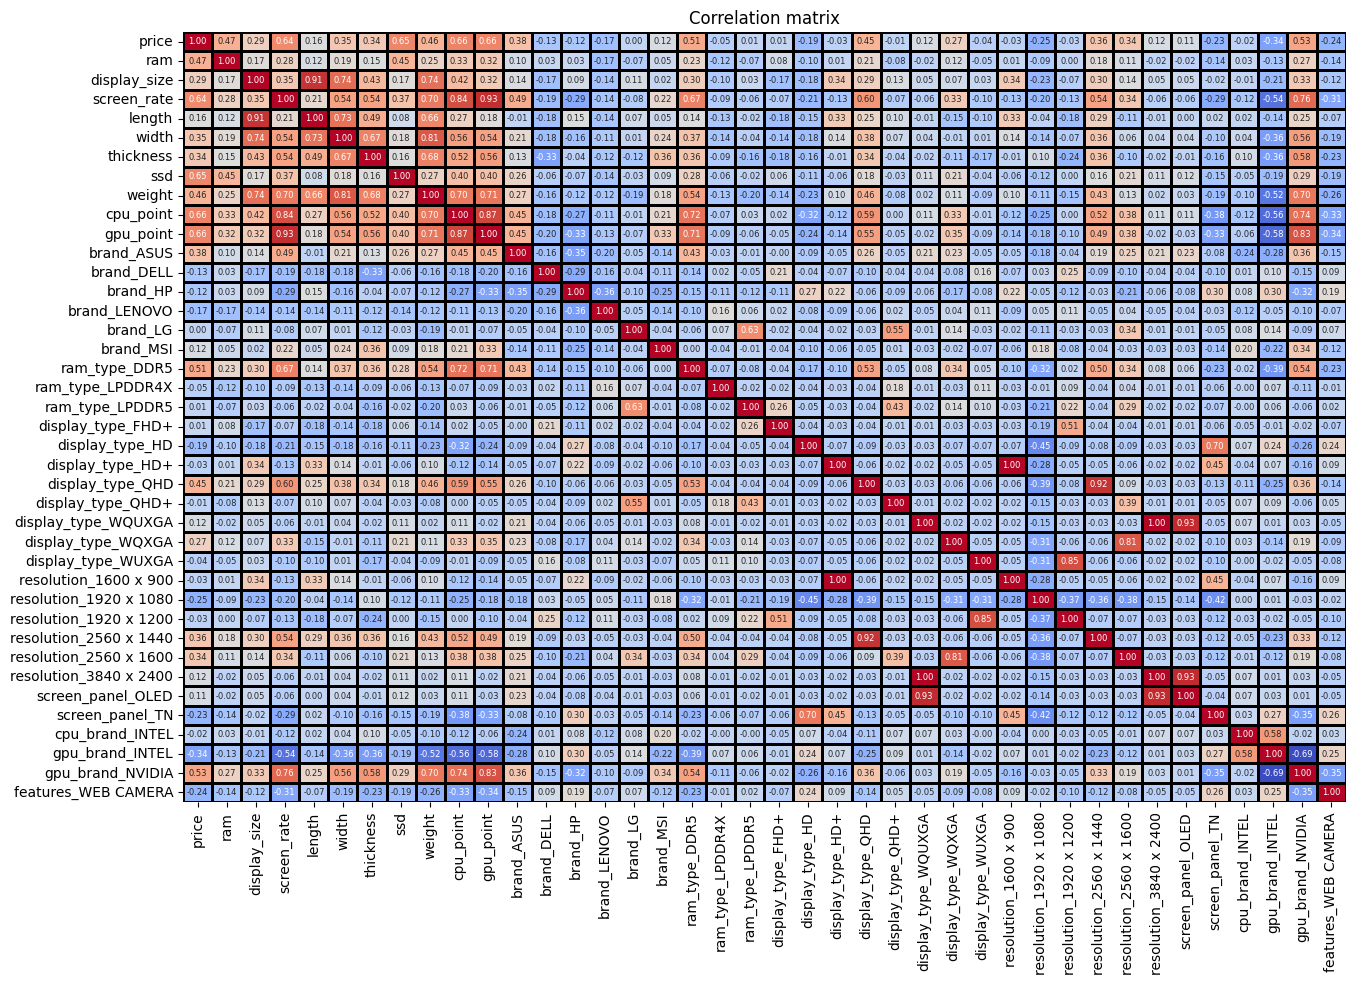

In [63]:
temp = trainset.drop(columns=['brand'], axis=1)
corr = temp.corr()
plt.figure(figsize=(15, 10))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f', annot_kws={
            'size': 6}, linewidths=1, linecolor='black', cbar=False)
plt.title('Correlation matrix')
plt.show()


In [64]:
# compare corr between features and remove one of them if corr > 0.9
def remove_corr_features(df):
    corr = df.corr()
    cols = corr.columns
    drop_cols = []
    for i in range(len(cols)):
        for j in range(i+1, len(cols)):
            if abs(corr.iloc[i, j]) > 0.9:
                drop_cols.append(cols[j])
    return drop_cols


drop_cols = remove_corr_features(temp)
print("Number of columns to drop:", len(drop_cols))
print("Columns to drop:", drop_cols)

Number of columns to drop: 7
Columns to drop: ['length', 'gpu_point', 'resolution_1600 x 900', 'resolution_2560 x 1440', 'resolution_3840 x 2400', 'screen_panel_OLED', 'screen_panel_OLED']


In [65]:
err_corr_drop = test_model(fe_X_train.drop(columns=drop_cols), fe_X_test.drop(columns=drop_cols), fe_y_train, fe_y_test)
print("MAPE after drop corr features:", err_corr_drop)

MAPE after drop corr features: 0.29598113161337


Kết quả: 
- Số đặc trưng bị xóa đi là 7 (còn 33 đặc trưng)
- Độ lỗi giảm từ 0.2963 -> 0.2959

### 2.6.3 RFE


In [66]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline


def rfe_feature_selection(X_train, X_test, y_train, y_test):
    err_list = []
    for i in range(1, len(X_train.columns) + 1):
        rfe = RFE(estimator=LinearRegression(), n_features_to_select=i)
        rfe.fit(X_train, y_train)
        X_train_rfe = rfe.transform(X_train)
        X_test_rfe = rfe.transform(X_test)
        error = test_model(X_train_rfe, X_test_rfe, y_train, y_test)
        err_list.append((i, error))
    return err_list


Min MAPE: 0.29630698430325464 with 38 features


Text(0.5, 1.0, 'RFE selected features')

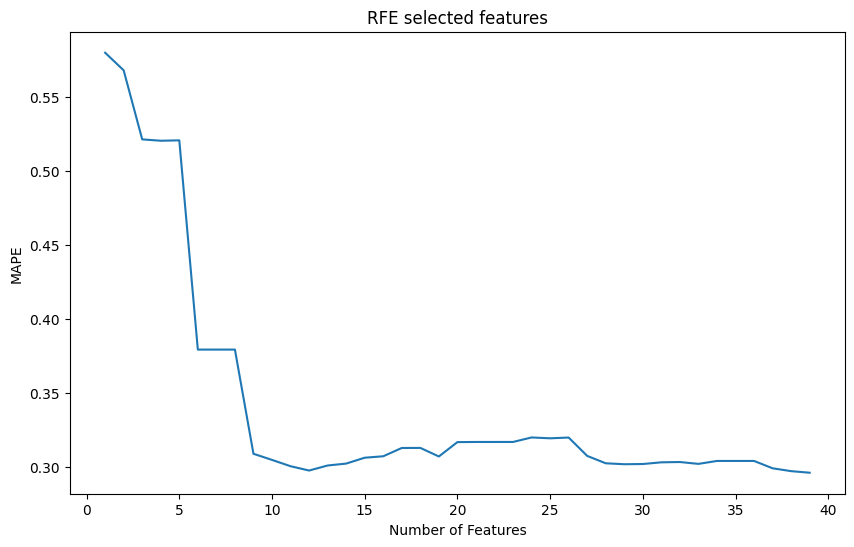

In [67]:
# print min error and number of features that give min error
err_rfe = rfe_feature_selection(fe_X_train, fe_X_test, fe_y_train, fe_y_test)
min_err3 = min(err_rfe, key=lambda x: x[1])
print("Min MAPE:", min_err3[1], "with", min_err3[0]-1, "features")
# plot error list
plt.figure(figsize=(10, 6))
plt.plot(*zip(*err_rfe))
plt.xlabel('Number of Features')
plt.ylabel('MAPE')
plt.title('RFE selected features')


Kết quả: 
- Số đặc trưng giảm còn 38 đặc trưng
- Độ lỗi gần như không thay đổi

### 2.6.4 PCA


- Ý tưởng: sử dụng PCA để giảm số chiều của dữ liệu, với số chiều chạy từ 1 đến số cột của dữ liệu

In [68]:
from sklearn.decomposition import PCA


def pca_feature_selection(X_train, X_test, y_train, y_test):
    err_list = []
    for i in range(1, len(X_train.columns) + 1):
        pca = PCA(n_components=i)
        pca.fit(X_train)
        X_train_pca = pca.transform(X_train)
        X_test_pca = pca.transform(X_test)
        error = test_model(X_train_pca, X_test_pca, y_train, y_test)
        err_list.append((i, error))
    return err_list


- Giảm số chiều với bộ dữ liệu trainset

Min MAPE: 0.27647458525436314 with 18 dimensions


Text(0.5, 1.0, 'PCA selected features')

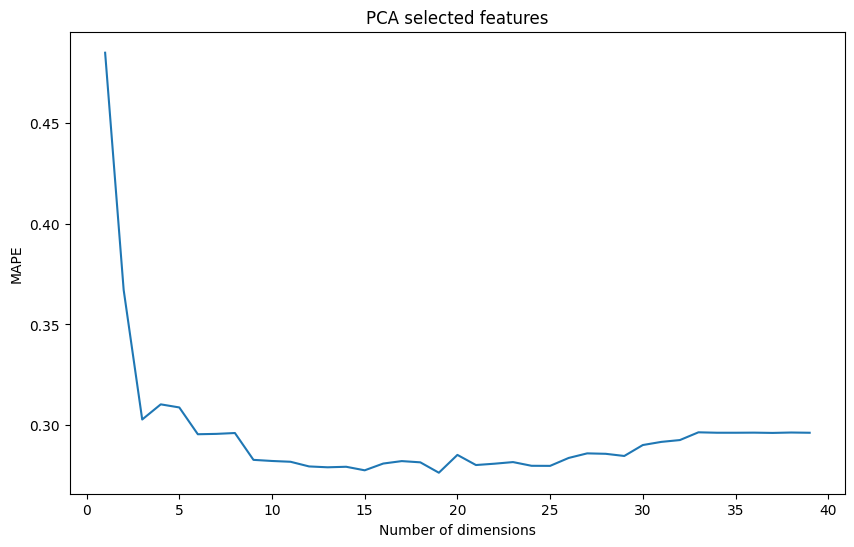

In [69]:
err_pca = pca_feature_selection(fe_X_train, fe_X_test, fe_y_train, fe_y_test)
min_err2 = min(err_pca, key=lambda x: x[1])
print("Min MAPE:", min_err2[1], "with", min_err2[0]-1, "dimensions")
plt.figure(figsize=(10, 6))
plt.plot(*zip(*err_pca))
plt.xlabel('Number of dimensions')
plt.ylabel('MAPE')
plt.title('PCA selected features')


Kết quả: 
- Số chiều cho độ lỗi thấp nhất là 18
- Độ lỗi giảm từ 0.2963 -> 0.2764 (~2%)

- Giảm số chiều với trường hợp feaure selection tốt nhất là top 15 đặc trưng có độ tương quan cao nhất với price trong trainset

In [70]:
df = pd.concat([X_train, y_train], axis=1)
best_col = df.corr()['price'].sort_values(ascending=False).head(15)
best_col = best_col.drop('price')
feat_col = best_col.index
feat_col

Index(['cpu_point', 'gpu_point', 'ssd', 'screen_rate', 'gpu_brand_NVIDIA',
       'ram_type_DDR5', 'ram', 'weight', 'display_type_QHD', 'brand_ASUS',
       'resolution_2560 x 1440', 'width', 'resolution_2560 x 1600',
       'thickness'],
      dtype='object')

Min MAPE: 0.2844415774507119 with 10 dimensions


Text(0.5, 1.0, 'PCA selected features')

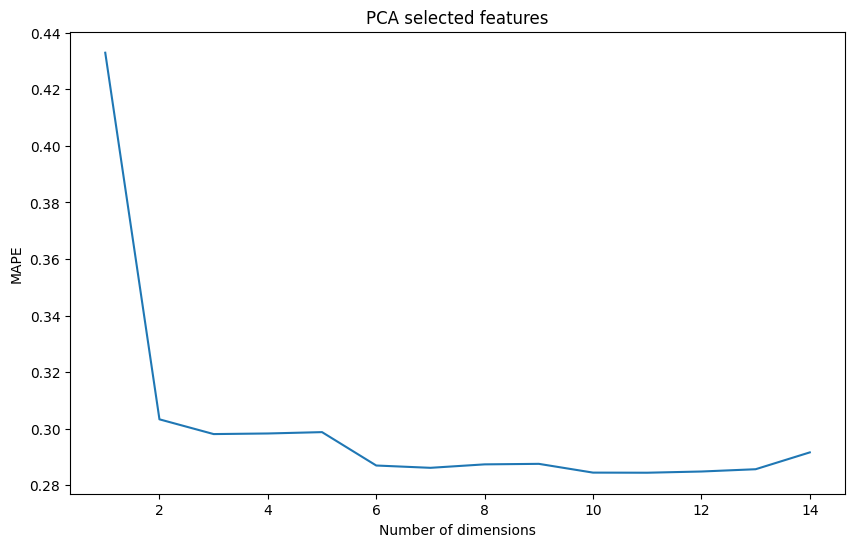

In [71]:

err_pca = pca_feature_selection(fe_X_train[feat_col], fe_X_test[feat_col], fe_y_train, fe_y_test)
min_err2 = min(err_pca, key=lambda x: x[1])
print("Min MAPE:", min_err2[1], "with", min_err2[0]-1, "dimensions")
plt.figure(figsize=(10, 6))
plt.plot(*zip(*err_pca))
plt.xlabel('Number of dimensions')
plt.ylabel('MAPE')
plt.title('PCA selected features')


Kết quả: 
- Có cải thiện độ lỗi từ độ lỗi gốc 0.2963 -> 0.2844 (~1%)
- Tuy nhiên độ lỗi vẫn cao hơn khi chỉ dùng PCA với bộ dữ liệu trainset

# 3. Mô hình hóa


## 3.1 Chuẩn bị dữ liệu huấn luyện


Từ kết quả phần lựa chọn đặc trưng ta chọn PCA với số chiều dữ liệu là 18 để giảm chiều dữ liệu trước khi tiến hành huấn luyện


In [72]:
pca = PCA(n_components=18)
pca.fit(X_train)
X_train = pca.transform(X_train)
X_test = pca.transform(X_test)
# convert X_train_pca to dataframe
X_train = pd.DataFrame(X_train)
X_test = pd.DataFrame(X_test)


## 3.2 Mô hình Linear Regression


In [73]:
# define model Linear Regression
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression
import math
import seaborn as sns


class ModelLinearRegression:
    """
    Class Model:
    Linear Regression's docs (using sklearn): https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html
    ---------------------
    Properties:
        model_pipeline: contain preprocessing pipeline + model.
        y_pred: list(float)
            Predicted values.
        score_mae: float 
            Mean absolute error score computed from y_pred and y_test (ground truth).
        score_rmse: float
            Root mean square error score computed from y_pred and y_test (ground truth).
        score_mape: float
            Mean absolute percentage error score computed from y_pred and y_test (ground truth).
    ---------------------
    Methods:
        __init__(self, preprocessing_pipeline):
            Initialize the model pipeline.
        
        train(self, X_train, y_train):
            Train the model using train dataset.
        
        predict(self, X_test):
            Predict the values using data in X_test.
        
        evaluate(self, y_true, y_pred):
            Evaluate the predict result by computing 3 metrics scores (MAE, RMSE, MAPE)
        
        plot_result(self, width, height, X_test, y_test):
            Visualize the result including predict values (blue), ground truth (yellow).
            
        plot_yy(self, width, height, x_test, y_test):
            Visualize the predicted values & ground truth.
    """

    def __init__(self):
        self.model = LinearRegression()

    def train(self, X_train, y_train):
        self.model.fit(X_train, y_train)

    def predict(self, X_test):
        self.y_pred = self.model.predict(X_test)
        return self.y_pred

    def evaluate(self, y_true, y_pred):
        self.score_mae = mean_absolute_error(y_true, y_pred)
        self.score_rmse = math.sqrt(mean_squared_error(y_true, y_pred))
        self.score_mape = mean_absolute_percentage_error(y_true, y_pred)

        print('MAE: {}'.format(self.score_mae))
        print('RMSE: {}'.format(self.score_rmse))
        print('MAPE: {}'.format(self.score_mape))

        return self.score_mae, self.score_rmse, self.score_mape

    def plot_result(self, width, height, X_test, y_test):
        f, ax = plt.subplots(1)
        f.set_figheight(height)
        f.set_figwidth(width)

        sns.lineplot(x=np.arange(
            0, X_test[:, 0].shape[0]), y=self.y_pred, ax=ax, color='blue', label='Predict')
        sns.lineplot(x=np.arange(
            0, X_test[:, 0].shape[0]), y=y_test, ax=ax, color='orange', label='Ground truth')

        ax.set_title(
            f'Prediction \n MAE: {self.score_mae:.2f}, RMSE: {self.score_rmse:.2f}, MAPE: {self.score_mape:.2f}', fontsize=14)
        ax.set_xlabel(xlabel='Sample', fontsize=14)
        ax.set_ylabel(ylabel='Price', fontsize=14)
        plt.show()

    def plot_yy(self, width, height, y_pred, y_test):
        f, ax = plt.subplots(1)
        f.set_figheight(height)
        f.set_figwidth(width)
        plt.scatter(y_test, y_pred, color='red')
        plt.plot(y_test, y_test)
        plt.grid()
        plt.xlabel('Actual price')
        plt.ylabel('Predicted price')
        plt.title('Scatter plot between actual y and predicted y')
        plt.show()


MAE: 407.13799988490285
RMSE: 536.7039498981829
MAPE: 0.3258532581295177


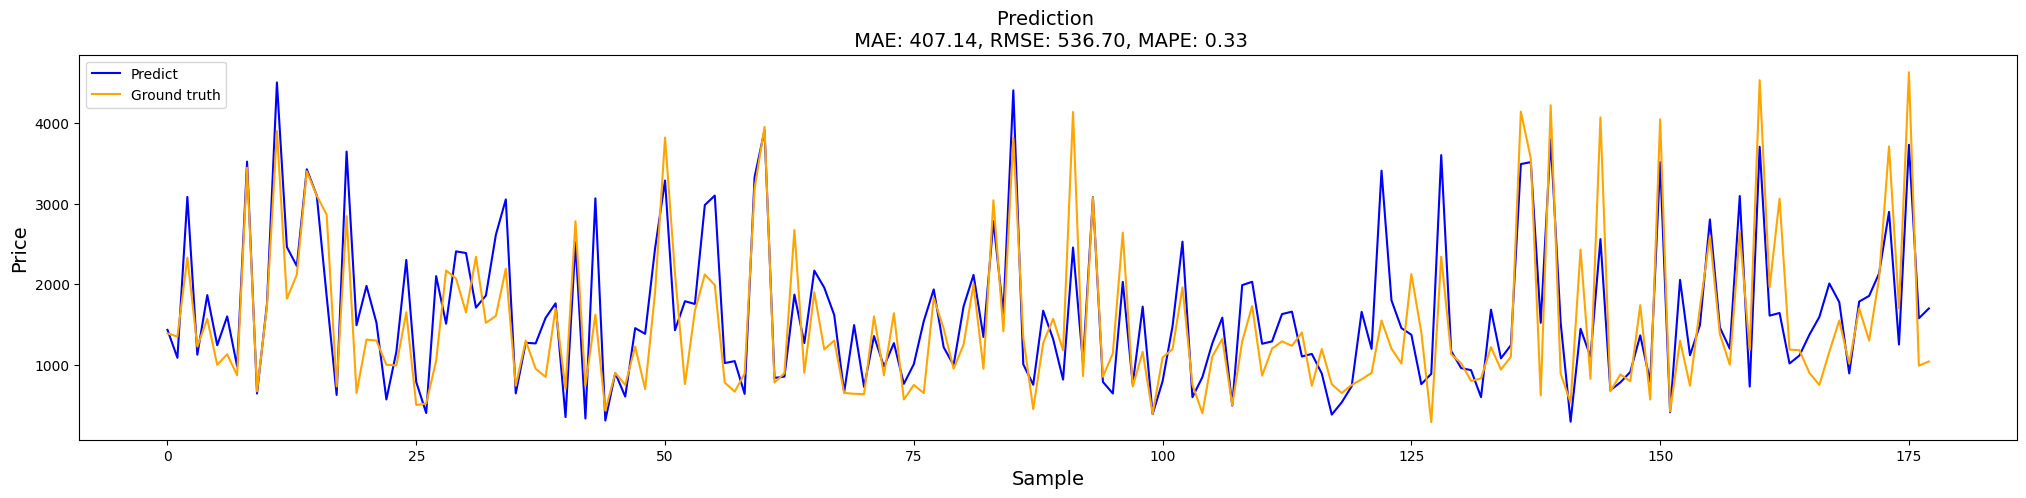

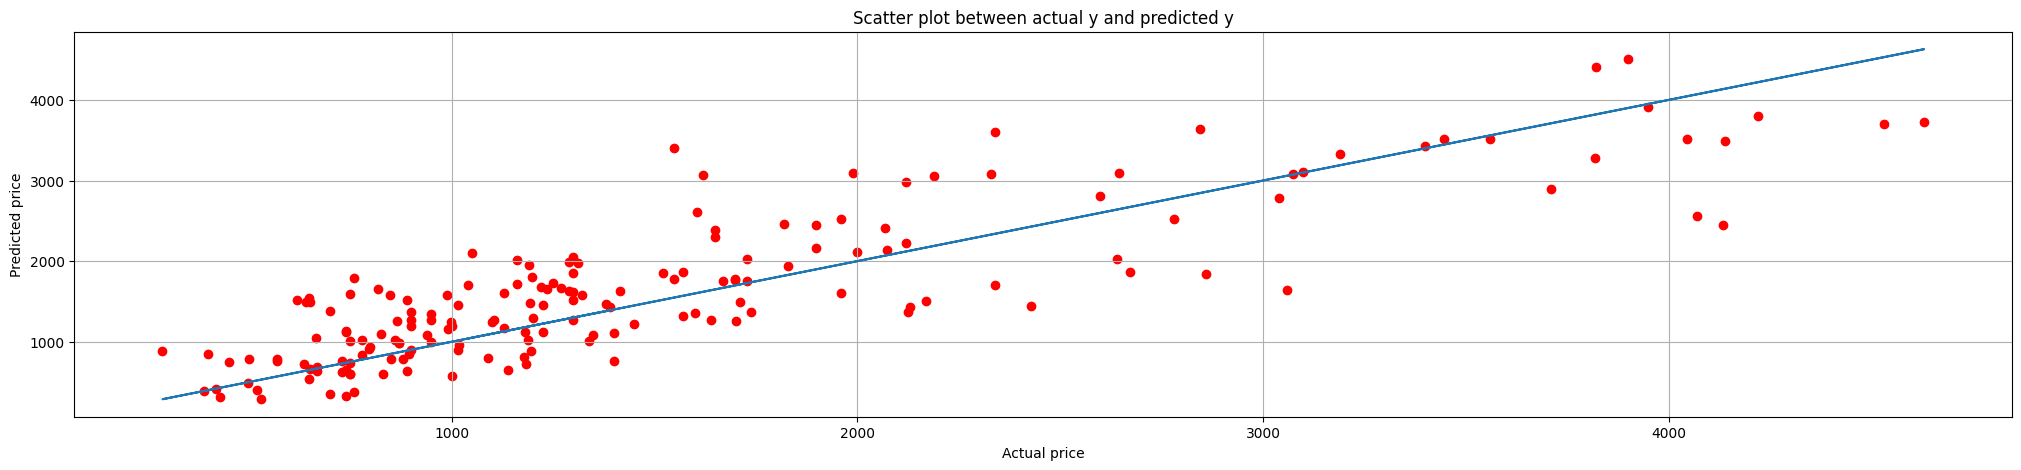

In [74]:
# Define model
linear_reg = ModelLinearRegression()

# Train model
linear_reg.train(X_train, y_train)

# Make prediction
linear_y_pred = linear_reg.predict(X_test)

# Evaluate model
linear_score_mae, linear_score_rmse, linear_score_mape = linear_reg.evaluate(y_test, linear_y_pred)

# Visualize metrics
linear_reg.plot_result(25, 5, X_test.values, y_test)
linear_reg.plot_yy(25, 5, linear_y_pred, y_test)


## 3.3 Mô hình Support Vector Regression


- Idea: Fit as many instances as possible on the street line while limiting the margin violations


In [75]:
from sklearn.svm import LinearSVR
from scipy.stats import uniform
from sklearn.model_selection import RandomizedSearchCV


class ModelSVR:
    """
    Class Model:
    Linear Support Vector Regression's docs (using sklearn): https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVR.html
    ---------------------
    Properties:
        model: Linear Support Vector Regression model.
        y_pred: list(float)
            Predicted values.
        score_mae: float 
            Mean absolute error score computed from y_pred and y_test (ground truth).
        score_rmse: float
            Root mean square error score computed from y_pred and y_test (ground truth).
        score_mape: float
            Mean absolute percentage error score computed from y_pred and y_test (ground truth).
    ---------------------
    Methods:
        __init__(self, preprocessing_pipeline):
            Initialize the model pipeline.
        
        train(self, X_train, y_train):
            Train the model using train dataset.
        
        predict(self, X_test):
            Predict the values using data in X_test.
        
        evaluate(self, y_true, y_pred) -> tuple(float):
            Evaluate the predict result by computing 3 metrics scores (MAE, RMSE, MAPE)
        
        plot_result(self, width, height, X_test, y_test):
            Visualize the result including predict values (blue), ground truth (yellow).
            
        plot_yy(self, width, height, x_test, y_test):
            Visualize the predicted values & ground truth.
    """

    def __init__(self):
        self.model = LinearSVR()

    def train(self, X_train, y_train):
        # Using randomized search CV technique to find the best hyperparameter for the linear svr model

        # Define the hyperparameter grid
        param_grid = {
            # Range of values for the C parameter
            'C': uniform(0.1, 10),
            # Range of values for the epsilon parameter
            'epsilon': uniform(0.01, 1)
        }

        rnd_search = RandomizedSearchCV(self.model, scoring="neg_root_mean_squared_error",
                                        param_distributions=param_grid, n_iter=100, random_state=42)
        rnd_search.fit(X_train, y_train)
        print("SVR Randomize score: " + str(rnd_search.best_score_))
        print("SVR GridSearch params: ")
        print(rnd_search.best_params_)

        self.model = rnd_search.best_estimator_

    def predict(self, X_test):
        self.y_pred = self.model.predict(X_test)
        return self.y_pred

    def evaluate(self, y_true, y_pred):
        self.score_mae = mean_absolute_error(y_true, y_pred)
        self.score_rmse = math.sqrt(mean_squared_error(y_true, y_pred))
        self.score_mape = mean_absolute_percentage_error(y_true, y_pred)

        print('MAE: {}'.format(self.score_mae))
        print('RMSE: {}'.format(self.score_rmse))
        print('MAPE: {}'.format(self.score_mape))

        return self.score_mae, self.score_rmse, self.score_mape

    def plot_result(self, width, height, X_test, y_test):
        f, ax = plt.subplots(1)
        f.set_figheight(height)
        f.set_figwidth(width)

        sns.lineplot(x=range(
            0, X_test[:, 0].shape[0]), y=self.y_pred, ax=ax, color='blue', label='Predict')
        sns.lineplot(x=range(0, X_test[:, 0].shape[0]), y=y_test,
                     ax=ax, color='orange', label='Ground truth')

        ax.set_title(
            f'Prediction \n MAE: {self.score_mae:.2f}, RMSE: {self.score_rmse:.2f}, MAPE: {self.score_mape:.2f}', fontsize=14)
        ax.set_xlabel(xlabel='Sample', fontsize=14)
        ax.set_ylabel(ylabel='Price', fontsize=14)
        plt.show()

    def plot_yy(self, width, height, y_pred, y_test):
        f, ax = plt.subplots(1)
        f.set_figheight(height)
        f.set_figwidth(width)
        plt.scatter(y_test, y_pred, color='red')
        plt.plot(y_test, y_test)
        plt.grid()
        plt.xlabel('Actual price')
        plt.ylabel('Predicted price')
        plt.title('Scatter plot between actual y and predicted y')
        plt.show()


SVR Randomize score: -791.8775033457224
SVR GridSearch params: 
{'C': 9.956504541106007, 'epsilon': 0.2520552715115004}
MAE: 368.3145668060966
RMSE: 544.4725883146008
MAPE: 0.2418060295982026


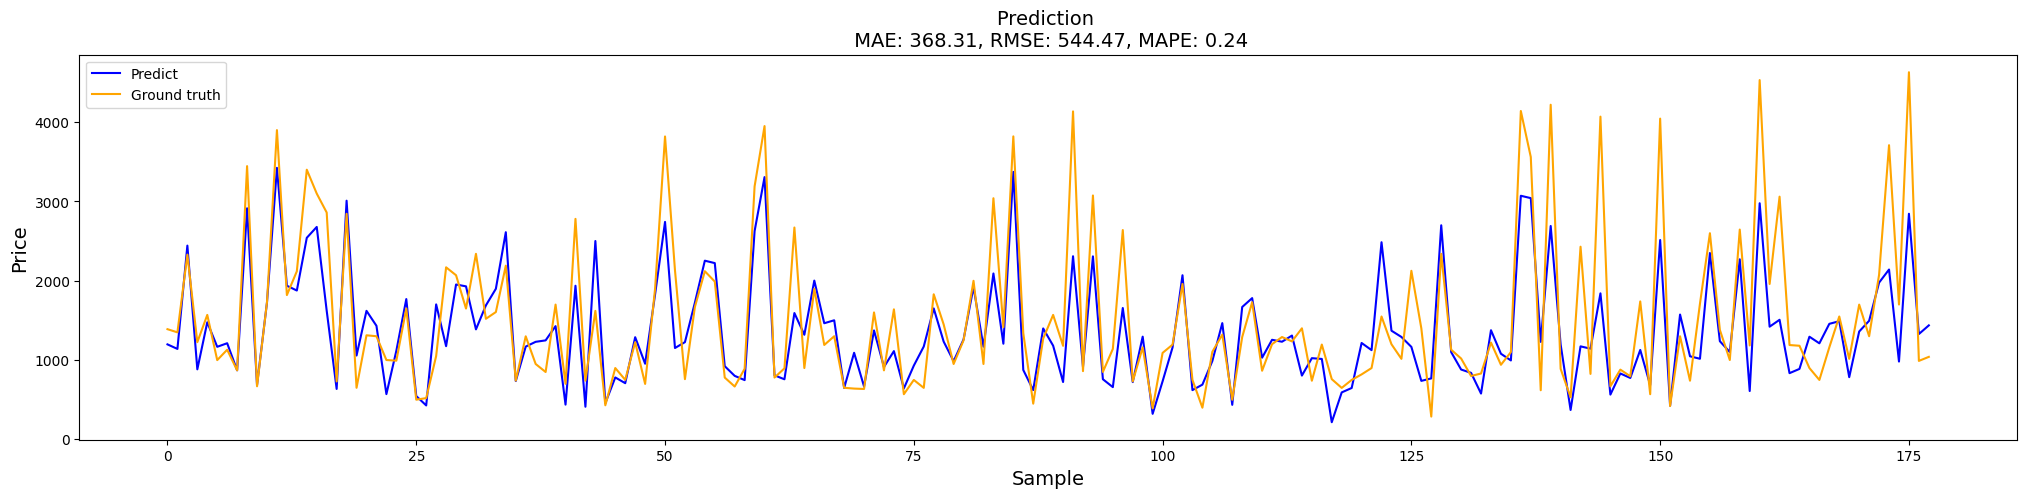

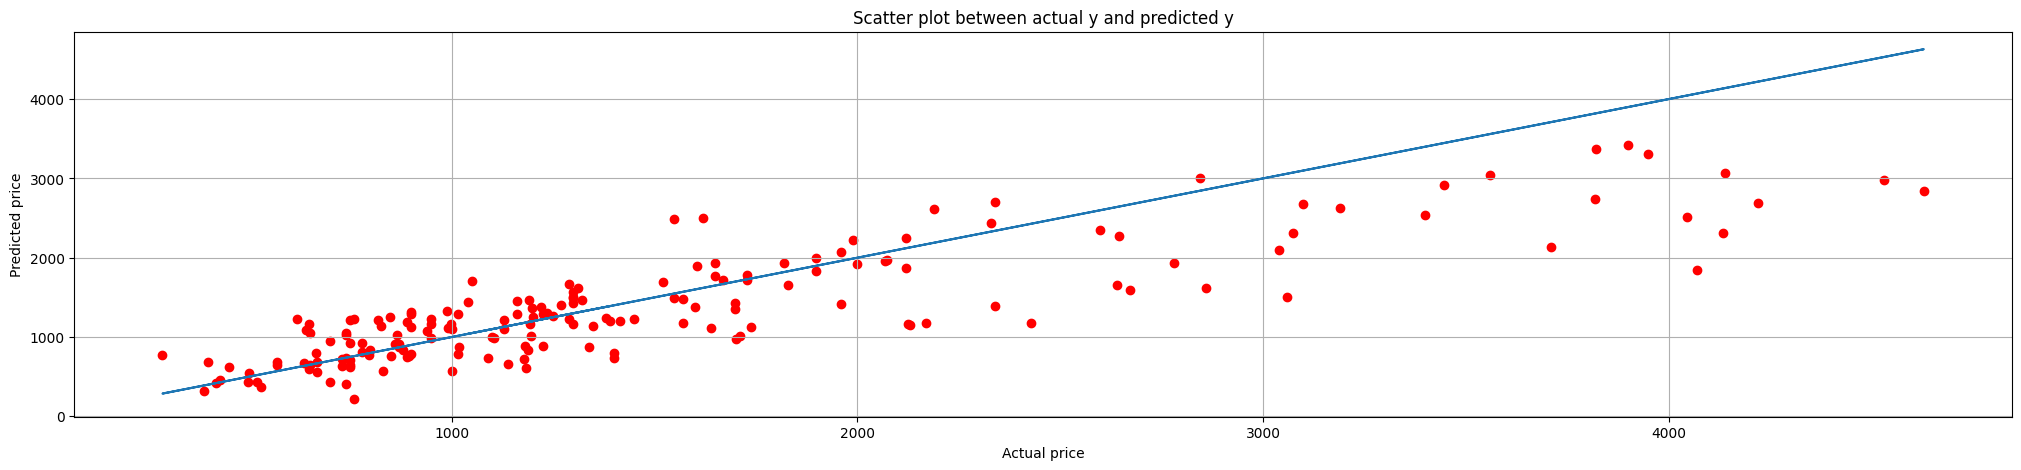

In [76]:
# Define model
svr_reg = ModelSVR()

# Train model
svr_reg.train(X_train, y_train)

# Make prediction
svr_y_pred = svr_reg.predict(X_test)

# Evaluate model
svr_score_mae, svr_score_rmse, svr_score_mape = svr_reg.evaluate(
    y_test, svr_y_pred)

# Plot results
svr_reg.plot_result(25, 5, X_test.values, y_test)
svr_reg.plot_yy(25, 5, svr_y_pred, y_test)


## 3.4 Kết quả

Bảng kết quả

| Mô hình | MAE (USD) | RMSE (USD) | MAPE (%) |
| --- | --- | --- | --- |
| Linear Regression | 407.1 | 536.7 | 33 |
| Support Vector Regression | 368.3 | 544.5 | 24 |

Nhận xét:
- Mô hình SVR cho kết quả tốt hơn so với Linear Regression đối với 2 độ đo MAE và MAPE
- Từ hai đồ thị scatter kết quả của giá dự đoán và giá thực tế ta thấy đối với cả hai mô hình, khi giá trị thực tế của laptop lớn hơn 4000USD, giá dự đoán của mô hình có xu hướng thấp hơn giá thực tế. Điều này có thể do dữ liệu của laptop có giá trị lớn hơn 4000USD ít hơn so với dữ liệu có giá trị nhỏ hơn 4000USD. Do đó, mô hình không học được nhiều về các laptop có giá trị lớn hơn 4000USD và dự đoán sai hơn so với các laptop có giá trị nhỏ hơn 4000USD.

Bảng kết quả với tập dữ liệu 10k

| Mô hình | MAE (USD) | RMSE (USD) | MAPE (%) |
| --- | --- | --- | --- |
| Linear Regression | 428.2 | 625.9 | 28 |
| Support Vector Regression | 422.9 | 691.2 | 24 |

- Ta thấy độ lỗi MAPE của mô hình Linear Regression và SVR trên tập 1K cao hơn trên tập 10K. Điều này có thể do tập 10K có nhiều dữ liệu hơn so với tập 1K và do đó mô hình học được nhiều hơn và dự đoán tốt hơn trên tập 1K.